# Cryptocurrency Fundamentals Analysis

Purpose:
    - Explore relationships between cryptocurrency git/github repositoriy activity and price/volatility 
    

### Load Fundamentals Data

The fundamentals data is accessible through the database that this repository's worker maintains. Update `config.py` with the database url for the source data

In [1]:
import os, sys
import pathlib
import pandas as pd
sys.path.insert(1, "/home/jupyter/fundamental_crypto_value")
import fundamentals

In [12]:
import config
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm.session import Session
from fundamentals.github_api import get_repo_db_stats

DATABASE_URL = 'FAKE_DEMO_DB_URL'
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()

query = """
WITH 
	dates as (SELECT generate_series(date '2017-06-01', date '2018-02-13', '1 day')::date as dt),
    
	analysis_pr as (
        SELECT   repo_id, dates.dt, sum(case when pull_requests.created_at::date = dates.dt then 1 else 0 end) pr_count
        FROM     pull_requests INNER JOIN dates ON True
        GROUP BY repo_id, dates.dt
    ),
    
    analysis_issues as (
        SELECT   repo_id, dates.dt, sum(case when issues.opened_at::date = dates.dt then 1 else 0 end) issues_count
        FROM     issues INNER JOIN dates ON True
        GROUP BY repo_id, dates.dt
    ),
    
    analysis_commits as (
        SELECT   
        	repo_id,
        	dates.dt,
            sum(case when commits.last_modified::date = dates.dt then additions::int else 0 end) commit_add_sum,
            sum(case when commits.last_modified::date = dates.dt then deletions::int else 0 end) commit_del_sum,
            sum(case when last_modified::date = dates.dt then 1 else 0 end) commit_count
		FROM commits INNER JOIN dates on True
    	GROUP BY repo_id, dates.dt
    ),
    
    analysis_stars as (
        SELECT   repo_id, dates.dt, sum(case when stars.starred_at::date = dates.dt then 1 else 0 end) star_count
        FROM     stars INNER JOIN dates ON True
        GROUP BY repo_id, dates.dt
    )
    
SELECT
	tracked.repo_id,
    tracked.symbol,
    dates.dt,
    analysis_pr.pr_count,
    analysis_issues.issues_count,
    analysis_commits.commit_add_sum,
    analysis_commits.commit_del_sum,
    analysis_commits.commit_count,
    analysis_stars.star_count
FROM
	tracked
    INNER JOIN dates on True
    INNER JOIN analysis_pr on tracked.repo_id = analysis_pr.repo_id and dates.dt = analysis_pr.dt
    INNER JOIN analysis_issues on tracked.repo_id = analysis_issues.repo_id and dates.dt = analysis_issues.dt
    INNER JOIN analysis_commits on tracked.repo_id = analysis_commits.repo_id and dates.dt = analysis_commits.dt
    INNER JOIN analysis_stars on tracked.repo_id = analysis_stars.repo_id and dates.dt = analysis_stars.dt
WHERE
    tracked.symbol in ('XMR', 'EOS', 'XVG', 'XRB', 'DCR', 'ZRX', 'FCT', 'NEO', 'SNT', 'LSK', 'DASH', 'WAVES', 'DRGN', 'XRP', 'REP', 'BTC', 'ZEC', 'XLM', 'RHOC', 'ETN', 'OMG', 'ZCL', 'PIVX', 'BTS', 'STEEM', 'ARK', 'ADA', 'DGB', 'SC', 'STRAT', 'DOGE', 'BCN', 'GNT', 'QTUM', 'BCH', 'BTG', 'LTC', 'ETH')
"""

/usr/local/lib/python3.5/dist-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [13]:
# Run the query
gh_data = pd.read_sql(query, con=engine)

# Extract symbols that were retrieved
symbols = set(gh_data.symbol.unique())

# Remap dt to date for convenience
gh_data = gh_data.rename(columns={'dt': 'date'})

# Convert date to string
gh_data['date'] = gh_data.date.apply(lambda x: str(x))

In [14]:
# Inspect a few records
gh_data.head(5)

,repo_id,symbol,date,pr_count,issues_count,commit_add_sum,commit_del_sum,commit_count,star_count
0,92181371,ZRX,2017-07-23,0,0,0,0,0,1
1,19352450,DASH,2017-07-26,2,2,0,0,0,2
2,87335980,EOS,2017-11-10,1,5,10455,10593,30,6
3,1181927,BTC,2017-12-16,4,4,3,2,3,91
4,66244442,DRGN,2017-06-14,0,0,0,0,0,0


In [15]:
gh_data.tail(5)

,repo_id,symbol,date,pr_count,issues_count,commit_add_sum,commit_del_sum,commit_count,star_count
9799,92181371,ZRX,2017-11-04,0,0,0,0,0,0
9800,66564704,STRAT,2017-08-16,1,1,0,0,0,0
9801,109060789,ETN,2017-09-22,0,0,6,3,1,0
9802,109060789,ETN,2017-12-06,0,3,1,0,1,0
9803,25370072,SC,2017-08-11,0,1,0,0,0,7


In [16]:
gh_data.describe()

,repo_id,pr_count,issues_count,commit_add_sum,commit_del_sum,commit_count,star_count
count,9.804000e+03,9804.000000,9804.000000,9.804000e+03,9.804000e+03,9804.000000,9804.000000
mean,4.772341e+07,1.225214,2.116585,2.141336e+03,1.258818e+03,3.621889,5.582721
std,2.875421e+07,2.175947,3.479348,3.308493e+04,2.948187e+04,8.640633,14.274026
min,1.181927e+06,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.935245e+07,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,4.832853e+07,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,1.000000
75%,7.091400e+07,2.000000,3.000000,1.440000e+02,5.800000e+01,3.000000,4.000000
max,1.090608e+08,24.000000,66.000000,1.547562e+06,2.505483e+06,208.000000,229.000000


### Load Currency Price Histories

Price histories for 200 assets are available in the `daily_ohlc_coinmarketcap` subfolder. We read in each dataframe and name it's columns by prepending the symbol name

In [17]:
PRICE_HISTORY_DIR = 'daily_ohlc_coinmarketcap'

In [19]:
dfs = []
hist_symbol = []
for path in pathlib.Path(PRICE_HISTORY_DIR).iterdir():
    filename = path.name
    symbol = filename.split('_', 1)[0]
    # Only Load Asset Histories where We have GitHub History
    if symbol in symbols:
        sdf = pd.read_csv(path,
                          usecols=[1,2,3,4,5,6,7],
                          header=0,
                          names=['{}_close'.format(symbol),
                                 '{}_date'.format(symbol),
                                 '{}_high'.format(symbol),
                                 '{}_low'.format(symbol),
                                 '{}_open'.format(symbol),
                                 '{}_usd_market_cap'.format(symbol),
                                 '{}_usd_volume'.format(symbol)])
        dfs.append(sdf)
        hist_symbol.append(symbol)
hist_symbol = set(hist_symbol)

In [20]:
# Inspect a few records
dfs[0].head(5)

,XRB_close,XRB_date,XRB_high,XRB_low,XRB_open,XRB_usd_market_cap,XRB_usd_volume
0,0.008675,2017-03-07,0.009104,0.007643,0.009104,-,23600
1,0.009707,2017-03-08,0.009798,0.007782,0.008672,351931,26158
2,0.008343,2017-03-09,0.009998,0.006985,0.008916,365399,27587
3,0.007292,2017-03-10,0.008461,0.006658,0.008349,345494,27405
4,0.007530,2017-03-11,0.008130,0.007228,0.007290,304571,7099


### Join Fundamentals and Price History On Date

Fundamentals data and price history data are both grouped by whole day on axis 1. If we pre-filter to 1 asset at a time, the components can be joined together into a single dataframe with fundamental and price history data

In [23]:
assets = {}
for symbol in hist_symbol:
    sym_fundamentals = gh_data[gh_data.symbol == symbol].copy().sort_values('date')
    sym_fundamentals = sym_fundamentals.set_index('date')
    sym_hist = [x for x in dfs if x.columns[0][:len(symbol)] == symbol][0]
    sym_hist = sym_hist.rename(columns={'{}_date'.format(symbol): 'date'})
    sym_hist = sym_hist.set_index('date')
    sym_df = pd.concat([sym_fundamentals, sym_hist], axis=1, join='inner')
    sym_df = sym_df.rename(columns=dict((x, x.lstrip('{}_'.format(symbol))) for x in list(sym_df.columns)))
    del sym_df['repo_id']
    assets[symbol] = sym_df.copy()
# Phew! That was ugly.

In [25]:
# review a few records
assets['BTC'].tail()

,symbol,pr_count,issues_count,commit_add_sum,commit_del_sum,commit_count,star_count,close,high,low,open,usd_market_cap,usd_volume
date,,,,,,,,,,,,,
2018-02-08,BTC,5,12,456,462,19,72,8265.59,8558.77,7637.86,7637.86,128714000000,9346750000
2018-02-09,BTC,4,9,96,18,2,11,8736.98,8736.98,7884.71,8271.84,139412000000,6784820000
2018-02-10,BTC,5,6,451,456,5,5,8621.90,9122.55,8295.47,8720.08,146981000000,7780960000
2018-02-11,BTC,4,5,15,12,2,49,8129.97,8616.13,7931.10,8616.13,145245000000,6122190000
2018-02-12,BTC,3,6,565,518,10,38,8926.57,8985.92,8141.43,8141.43,137258000000,6256440000


## Looking for Relationships

For the purposes of this analysis, we'll select bitcoin (BTC) for review as it has the longest price history and a the most fundamental record instances.

Changing the 'symbol' parameter will adjust these metrics for any other asset that is tracked

When looking for relationships we'll first visualize the data in charts. Next, we'll look for any strong relationships among:
    - Fundamentals against returns
    - Fundamentals against volatility

In [26]:
# Set out asset
symbol = 'BTC'

### Measure Daily Return and Volatility

Our measure of volatility is the daily range as a percentage of the daily range midpoint

In [27]:
# Copy the frame so we don't accidentally update the original data
df = assets[symbol].copy()

# Compute daily return percentage
df['return_pcnt'] = (df.close - df.open) / df.close

# Compute daily range pcnt of daily midpoint as proxy for daily volatility
df['volatility_pcnt'] = (df.high - df.low) / ((df.high + df.low) / 2)

### Plotting the Asset

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5,1,'GitHub Stargazers')

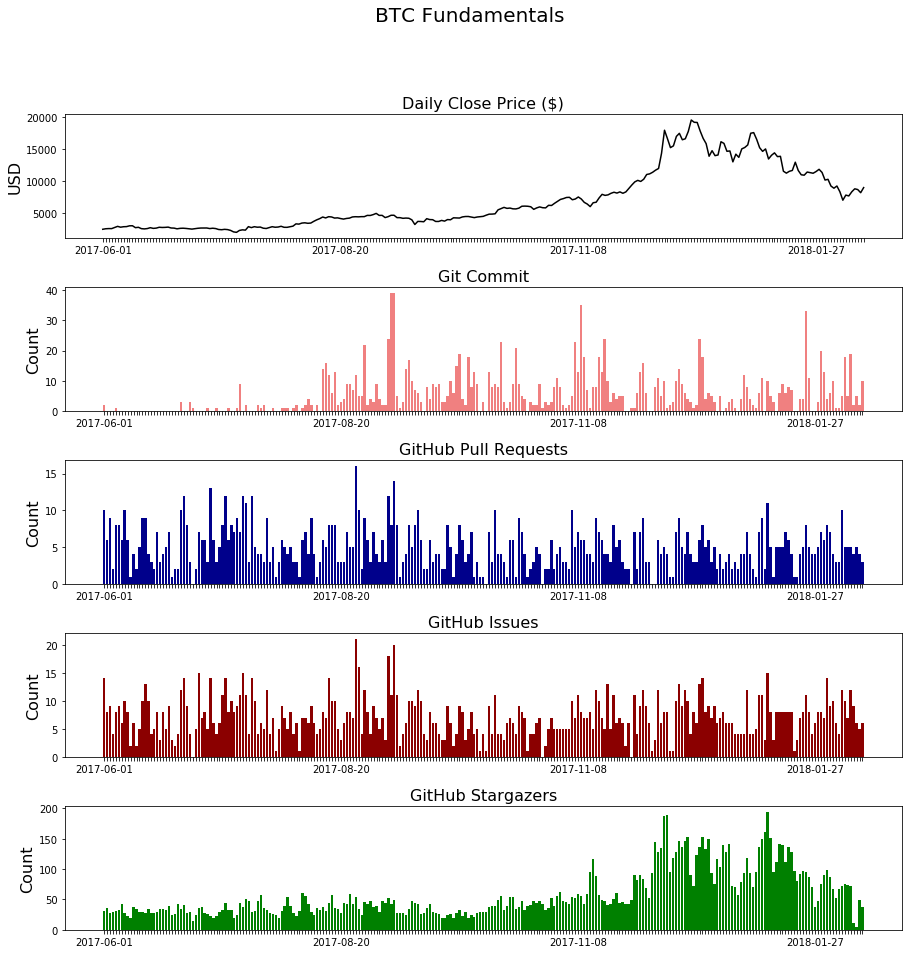

In [31]:
# Note: 
#    Not pictured = here commit_additions, commit_deletions
fig = plt.figure(1, figsize=(15,15))

plt.subplots_adjust(hspace=0.4)

ax = plt.subplot(511)
plt.plot(df.index, df.close, color='black')
fig.suptitle('{} Fundamentals'.format(symbol), size=20)
for ix, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(True) if ix % 80 == 0 else label.set_visible(False)
ax.set_ylabel('USD', size=16)
ax.set_title('Daily Close Price ($)', size=16)

ax = plt.subplot(512)
plt.bar(df.index, df.commit_count, color='lightcoral')
for ix, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(True) if ix % 80 == 0 else label.set_visible(False)
ax.set_ylabel('Count', size=16)
ax.set_title('Git Commit', size=16)

ax = plt.subplot(513)
plt.bar(df.index, df.pr_count, color='darkblue')
for ix, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(True) if ix % 80 == 0 else label.set_visible(False)
ax.set_ylabel('Count', size=16)
ax.set_title('GitHub Pull Requests', size=16)

ax = plt.subplot(514)
plt.bar(df.index, df.issues_count, color='darkred')
for ix, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(True) if ix % 80 == 0 else label.set_visible(False)
ax.set_ylabel('Count', size=16)
ax.set_title('GitHub Issues', size=16)

ax = plt.subplot(515)
plt.bar(df.index, df.star_count, color='green')
for ix, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(True) if ix % 80 == 0 else label.set_visible(False)
ax.set_ylabel('Count', size=16)
ax.set_title('GitHub Stargazers', size=16)

## Correlation in Returns and Volatility

We can evaluate the directions of any relationships between cryptocurrency fundamentals against return percent and volatility percent using Pearson's correlation

In [32]:
df.corr()[['return_pcnt', 'volatility_pcnt']].loc[['pr_count', 'issues_count', 'commit_add_sum',
       'commit_del_sum', 'commit_count', 'star_count']]

,return_pcnt,volatility_pcnt
pr_count,-0.067309,0.058738
issues_count,-0.051329,0.102122
commit_add_sum,-0.124139,0.045182
commit_del_sum,-0.017176,0.076151
commit_count,0.030351,0.041916
star_count,-0.069830,0.447668


### Discussion

The 8 month fundamentals on close price visualization does not outline any obvious trends. 

In contrast, the linear relationships (correlation) among fundamentals features, daily returns & daily volatility are more clear. Specifically, daily return is slightly negatively correlated with increased activity in fundamenatls and volatility is slightly positively correlated with increased fundamentals activity.

In isolation, one of correlation coefficients may be taken as spurious but the consistency in the relationships between each independent variable and the dependent variables suggests significance.

It is important to recognize that this relationship does directly suggest causality and, if there is partial causal, the direction of the information flow among fundamentals and price features has not been established. 

With those few caveats, this is an interesting line of research that has potential to inform trading decisions.

### Potential Future Work

- Establish direction of information flow
    - Transfer entropy + mutual information would be good choices
    - Account for cyclical trends and/or autocorrelation
        - Explore lag depths
- Apply smoothing to fundamentals features to enable 'trend' graphs

- Evaluate relationships among fundamentals and public sentiment